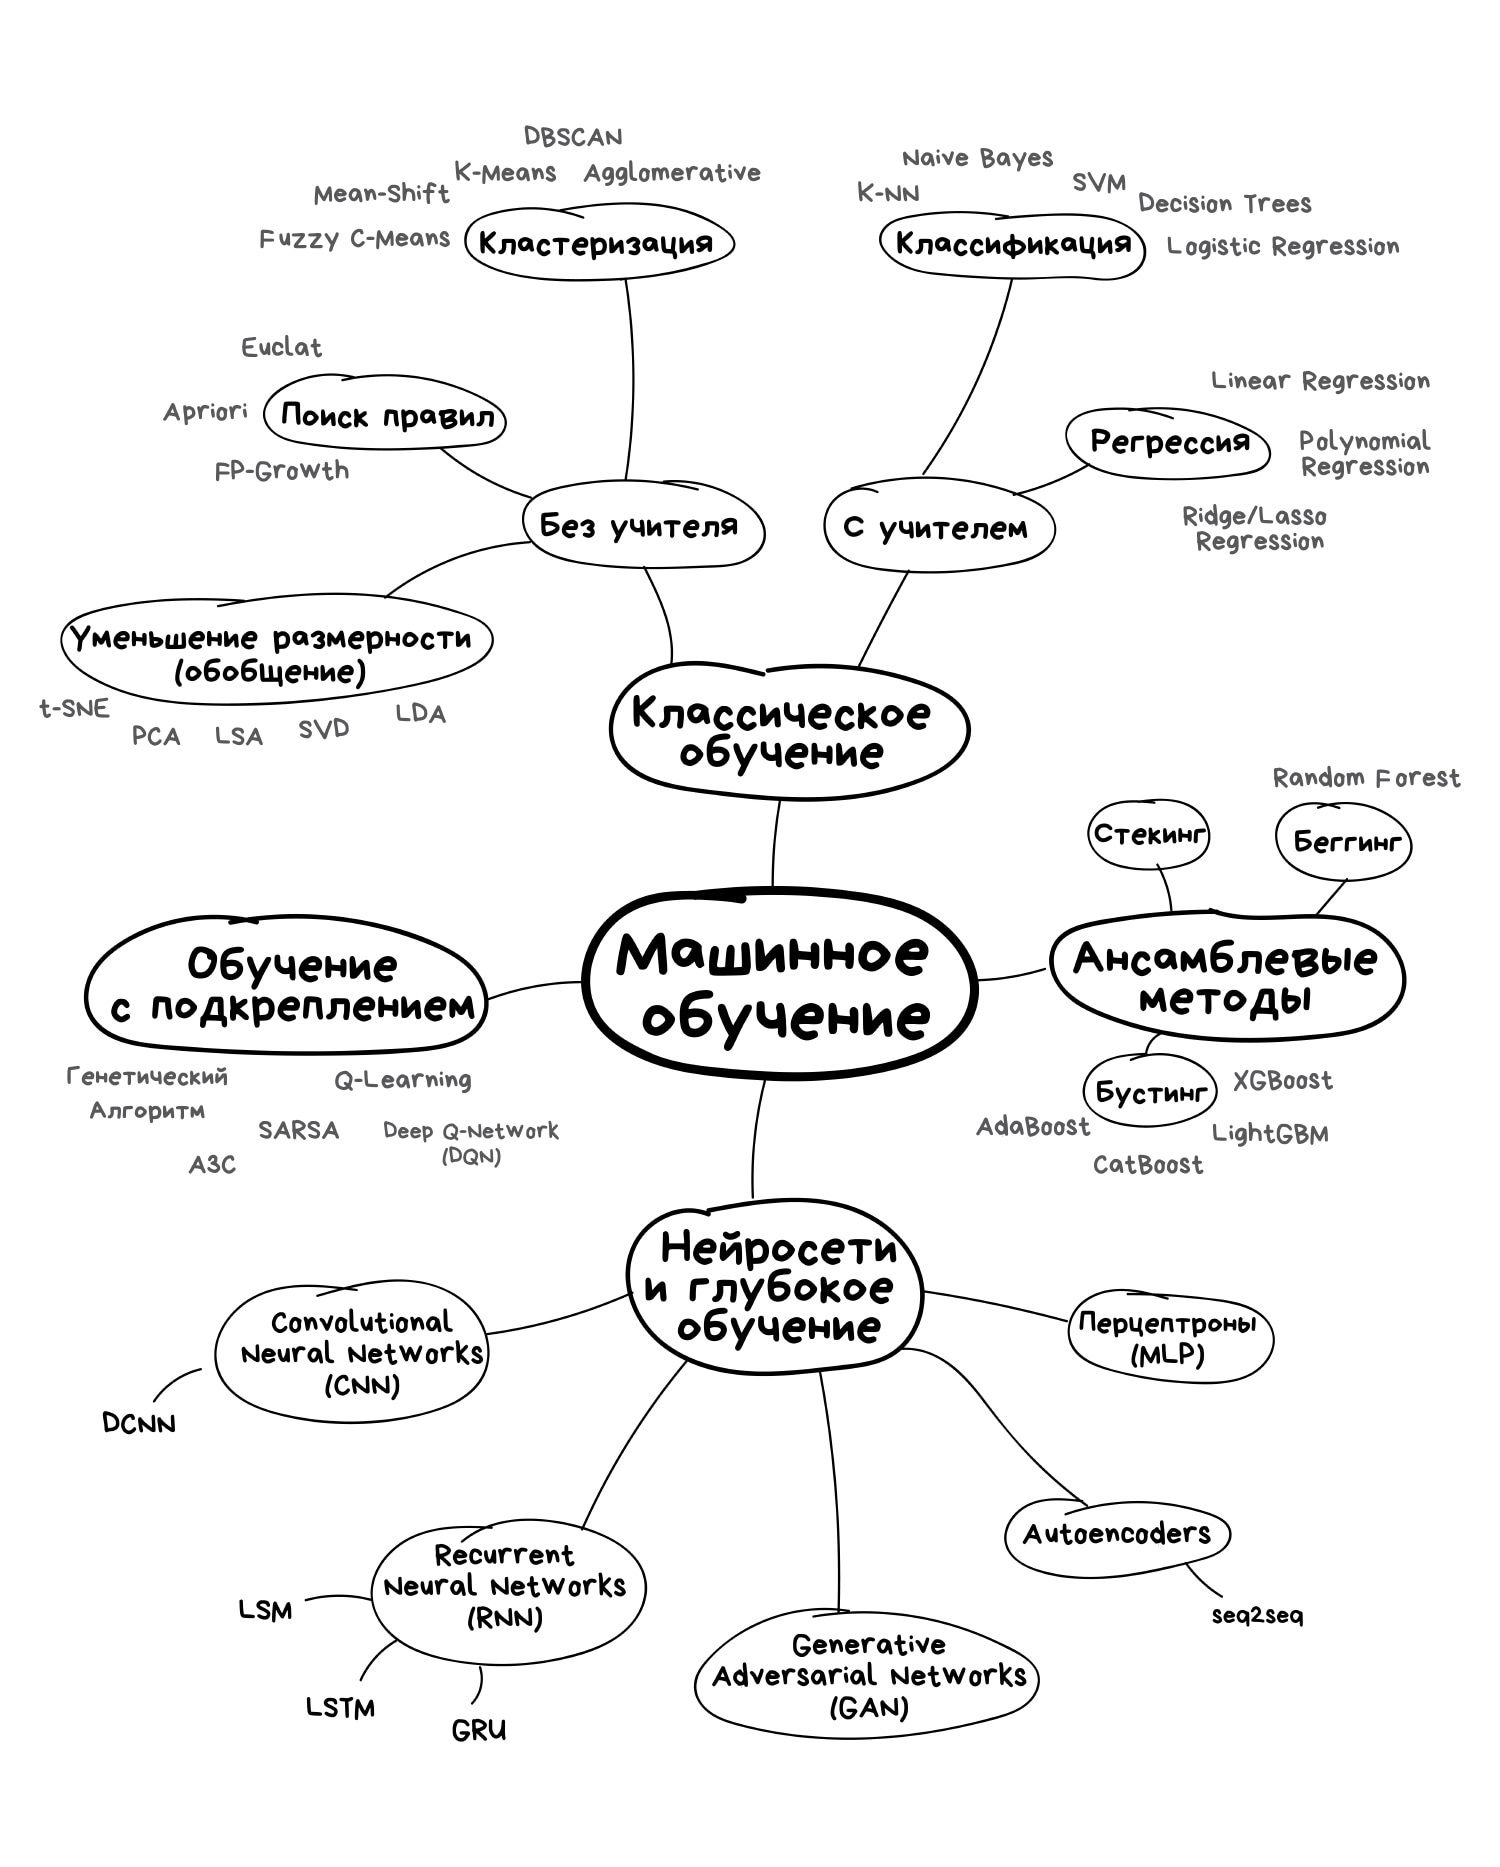

#Классификация

## K-NN

###Описание

**Метод ближайших соседей** (k Nearest Neighbors, или kNN) — простой алгоритм классификации (регрессии), основанный на оценивании сходства объектов.

Суть метода проста: объект относится к тому классу, к которому принадлежит большинство из его ближайших k соседей.

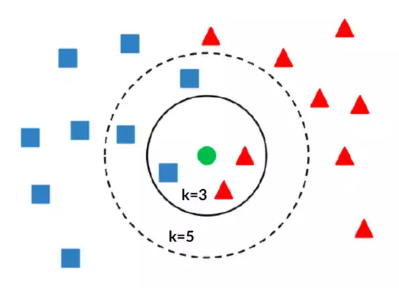

###Алгоритм

На вход принимать матрицу фичей в виде датафрейма пандаса.
Для каждого объекта тестовой выборки последовательно выполнить следующие шаги:
Вычислить расстояние до каждого объекта из обучающей выборки.
Сейчас расстояние будем вычислять по формуле Евклида (на следующих шагах рассмотрим и другие метрики). Для двух точек с тремя координатами (фичами) Евклидово расстояние считается так:
Отобрать k объектов обучающей выборки, расстояние до которых минимально.
Определить, какой класс наиболее часто встречается (мода) – это и будет классом целевого объекта.
Если число объектов в каждом из классов одинаковое, возвращаем класс 1.

###**Метрики**

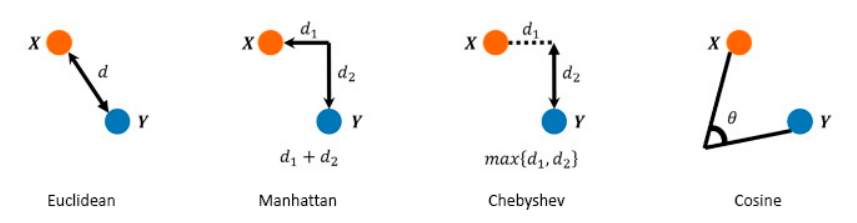

###**Взвешенный KNN**

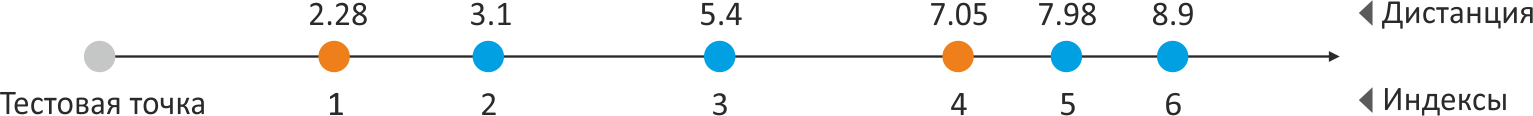

**1. Порядковый номер (rank)**

В этом варианте соседу приписывается вес обратно пропорциональный порядковому номеру соседа в отсортированном по удаленности списке.

Тогда вес каждого класса это сумма весов соседей из класса нормированная на сумму весов всех соседей:

$Q_j = \frac{\sum_{i=1}^{n_j} \frac{1}{R_{ij}}}{\sum_{i=1}^{n} \frac{1}{R_i}}$

где:
- $Q_j$ - вес 𝑗-го класса
- $R_{ij}$ - порядковый номер 𝑖-го соседа 𝑗-го класса
- $R_i$ - порядковый номер 𝑖-го соседа

В результате объекту приписывается класс, который набирает наибольший суммарный вес среди k ближайших соседей.

**2. Дистанция (distance)**

Здесь вес соседа зависит напрямую от расстояния до него. Чем меньше расстояние, тем более значимый вклад вносит голос.

А вес каждого класса определяется следующим образом:

$Q_j = \frac{\sum_{i=1}^{n_j} \frac{1}{D_{ij}}}{\sum_{i=1}^{n} \frac{1}{D_i}}$

где:
- $Q_j$ - вес 𝑗-го класса
- $D_{ij}$ - дистанция 𝑖-го соседа 𝑗-го класса
- $D_i$ - дистанция  𝑖-го соседа
Как и в предыдущем варианте, побеждает класс набравший наибольший вес.

**Пример:**

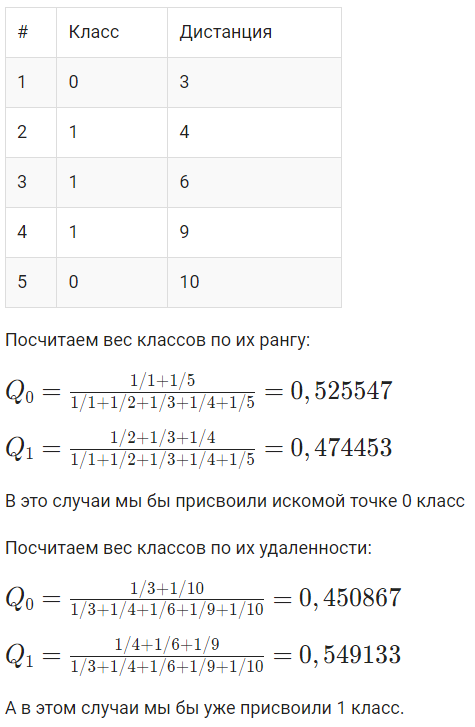

###Плюсы и минусы

**Плюсы:**
- Простая реализация.
- Неплохая интерпретация: можно объяснить, почему тестовый пример был классифицирован именно так.

**Минусы:**
- Как правило метод работает медленно. Особенно на больших тренировочных наборах.
- Неэффективный по памяти, поскольку нужно хранить в модели всю обучающую выборку.
- Если в наборе данных много признаков, то трудно определить, какие признаки не важны для классификации (регрессии).
- В случае малого числа соседей метод чувствителен к выбросам, т.е. склонен переобучаться.

###Своя реализация

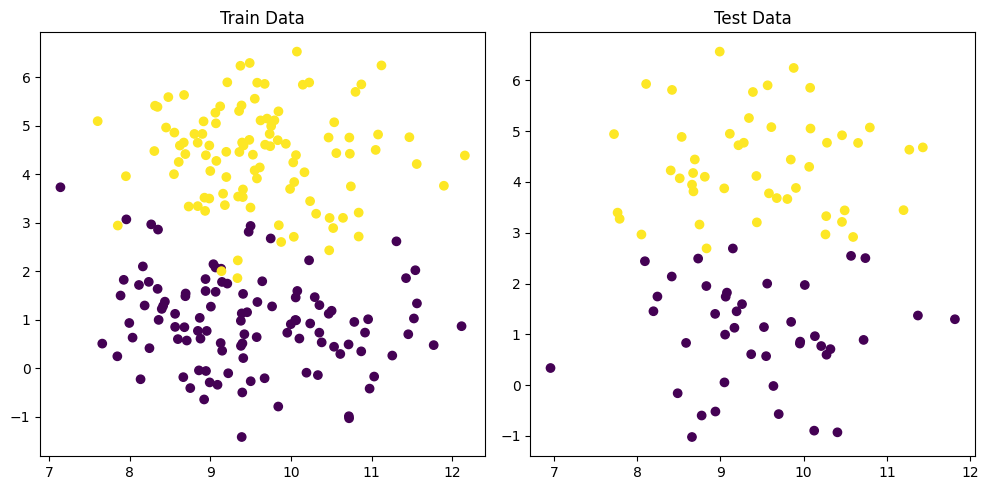

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=300, n_features=2, centers=2, random_state=4)
X = pd.DataFrame(X)
y = pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(X_train[0], X_train[1], c=y_train)
ax1.set_title("Train Data")

ax2.scatter(X_test[0], X_test[1], c=y_test)
ax2.set_title("Test Data")

plt.tight_layout()
plt.show()

In [11]:
class MyKNNClf():
    def __init__(self,
                 k=3,
                 metric='euclidean',  # euclidean, chebyshev, manhattan, cosine - метрики
                 weight='uniform'):  # uniform, rank, distance - взвешанный knn
        self.k = k
        self.train_size = None
        self.X = None
        self.y = None
        self.metric = metric
        self.metrics = {
            'euclidean': lambda row: np.sqrt(np.sum((row - self.X) ** 2, axis=1)),
            'chebyshev': lambda row: np.max(np.abs(row - self.X), axis=1),
            'manhattan': lambda row: np.sum(np.abs(row - self.X), axis=1),
            'cosine': lambda row: 1 - (np.dot(self.X, row) / (np.linalg.norm(self.X, axis=1) * np.linalg.norm(row)))
        }
        self.weight = weight

    def __str__(self):
        return f"MyKNNClf class: k={self.k}, metric={self.metric}, weight={self.weight}"

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.train_size = np.shape(X)
        return self.train_size

    def predict_y(self, row):
        distances = self.metrics[self.metric](row).sort_values().head(self.k)
        sorted_k_index = distances.index
        y_index = self.y[sorted_k_index].reset_index(drop=True)

        if self.weight == 'uniform':
            return y_index.mean()

        elif self.weight == 'rank':
            weights = 1 / (np.arange(1, self.k + 1))
            weighted_sum = np.sum(weights * y_index)
            return weighted_sum / np.sum(weights)

        elif self.weight == 'distance':
            weights = 1 / (distances)
            weighted_sum = np.sum(weights * np.array(y_index))
            return weighted_sum / np.sum(weights)

    def predict(self, X):
        return self.predict_proba(X).apply(lambda x: 1 if x >= 0.5 else 0)

    def predict_proba(self, X):
        return X.apply(self.predict_y, axis=1)

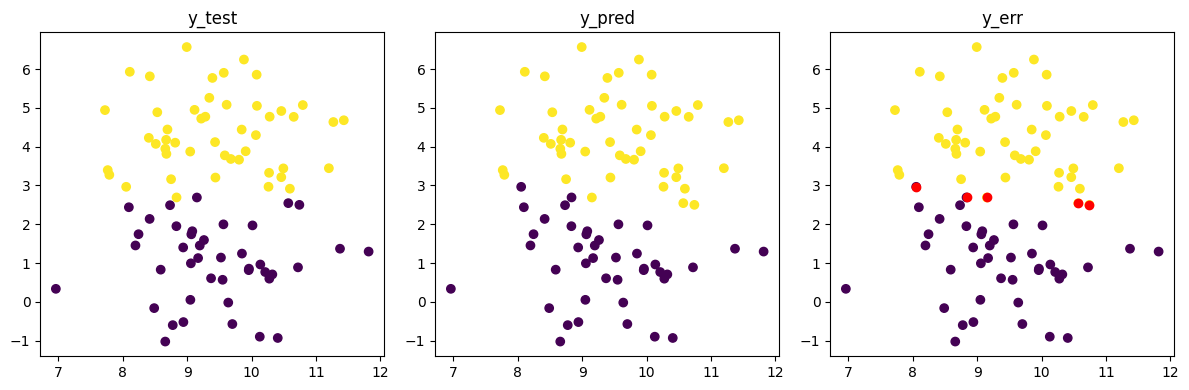

In [12]:
k = 100

KNN = MyKNNClf(k, weight = 'distance')
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(X_test[0], X_test[1], c=y_test)
ax1.set_title("y_test")

ax2.scatter(X_test[0], X_test[1], c=y_pred)
ax2.set_title("y_pred")

ax3.scatter(X_test[0], X_test[1], c=y_pred)
ax3.set_title("y_err")

err_ind = np.where(y_pred != y_test)[0]
X_test_sort = X_test.reset_index(drop=True)
ax3.scatter(X_test_sort.iloc[err_ind, 0], X_test_sort.iloc[err_ind, 1], c='red')

plt.tight_layout()
plt.show()

###Использование библиотеки

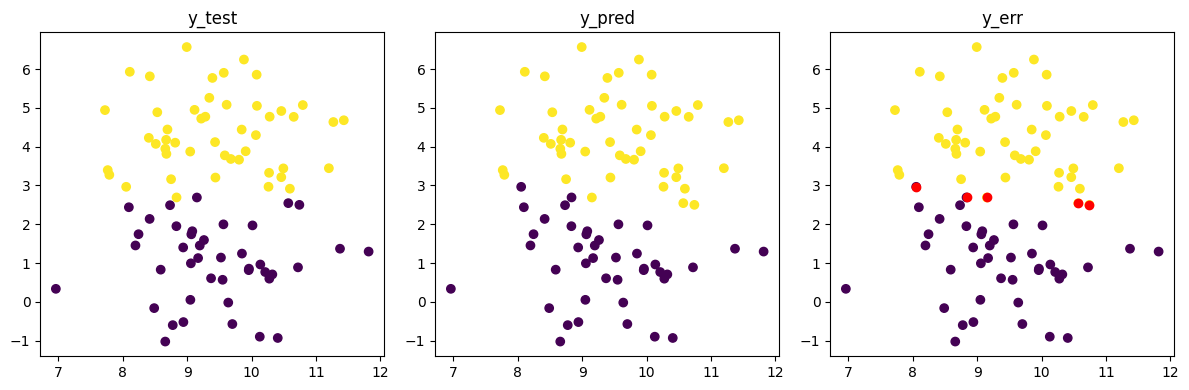

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 100, metric='euclidean', weights= 'distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(X_test[0], X_test[1], c=y_test)
ax1.set_title("y_test")

ax2.scatter(X_test[0], X_test[1], c=y_pred)
ax2.set_title("y_pred")

ax3.scatter(X_test[0], X_test[1], c=y_pred)
ax3.set_title("y_err")

err_ind = np.where(y_pred != y_test)[0]
X_test_sort = X_test.reset_index(drop=True)
ax3.scatter(X_test_sort.iloc[err_ind, 0], X_test_sort.iloc[err_ind, 1], c='red')

plt.tight_layout()
plt.show()

##Naive bayes

###Описание